In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import os

from torchvision import datasets, transforms, models , utils
from torch.utils.data import random_split

In [ ]:
def imshow(img):
  ''' function to show image '''
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [ ]:
def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [ ]:
# Training class

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy

        return {'val_loss': loss.detach(), 'val_acc': acc}
        

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
# Model training and evaluation

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    
    history = []
    optimizer = opt_func(model.parameters(),lr, momentum = 0.5)
    # optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            print(loss)

            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        print(result['train_loss'])
        print(result)
        model.epoch_end(epoch, result)
        history.append(result)
        classes_check(val_loader, model)
    
    return history

def classes_check(val_batches, model):
    classes = ('cherry', 'strawberry', 'tomato')
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in val_batches:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                             accuracy))

In [ ]:
# MLP model

class FruitClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(270000, 64)
        self.layer2 = torch.nn.Linear(64, 12)
        self.layer3 = torch.nn.Linear(12, 10)
        
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
##############################
#                            #
#     Running Model          #
#                            #
##############################

In [ ]:
# Import training images from zipped folder in Colab directory
from google.colab import drive
drive.mount('/content/drive')

# !unzip /content/traindata_postselection.zip
!unzip /content/traindata.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/traindata.zip
replace traindata/strawberry/strawberry_0943.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
notebook_path = os.path.abspath("MLPClassifier.ipynb")
# data_dir = os.path.join(os.path.dirname(notebook_path), "traindata_postselection")
data_dir = os.path.join(os.path.dirname(notebook_path), "traindata")

# dataset = datasets.ImageFolder(data_dir,transform = transforms.Compose([
#     transforms.Resize((300, 300)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(),
#     transforms.ToTensor(), 
#     transforms.Normalize(0.5, 0.5, 0.5)
# ]))

dataset = datasets.ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
]))

In [ ]:
batch_size = 30
# batch_size = 8
val_size = 500
train_size = len(dataset) - val_size

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = torch.utils.data.DataLoader(train_data, batch_size, shuffle = True)
val_dl = torch.utils.data.DataLoader(val_data, batch_size*2)

Length of Train Data : 4000
Length of Validation Data : 500


In [ ]:
# Load into the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

device

device(type='cpu')

In [ ]:
# Load model to the device
model = FruitClassification()
to_device(model, device)
model

FruitClassification(
  (layer1): Linear(in_features=270000, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=12, bias=True)
  (layer3): Linear(in_features=12, out_features=10, bias=True)
)

In [ ]:
# Initial evaluation of the model
evaluate(model, val_dl)

{'val_acc': 0.018518518656492233, 'val_loss': 2.2710485458374023}

In [ ]:
#set the no. of epochs, optimizer funtion and learning rate
num_epochs = 20
opt_func = torch.optim.SGD
# opt_func = torch.optim.Adam
lr = 0.01
# lr = 0.001
# lr = 0.0001

In [ ]:
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

tensor(2.2797, grad_fn=<NllLossBackward>)
tensor(2.2732, grad_fn=<NllLossBackward>)
tensor(2.0548, grad_fn=<NllLossBackward>)
tensor(2.8060, grad_fn=<NllLossBackward>)
tensor(1.7504, grad_fn=<NllLossBackward>)
tensor(1.4003, grad_fn=<NllLossBackward>)
tensor(1.3254, grad_fn=<NllLossBackward>)
tensor(1.2929, grad_fn=<NllLossBackward>)
tensor(1.1652, grad_fn=<NllLossBackward>)
tensor(1.6605, grad_fn=<NllLossBackward>)
tensor(2.0878, grad_fn=<NllLossBackward>)
tensor(1.3317, grad_fn=<NllLossBackward>)
tensor(1.4519, grad_fn=<NllLossBackward>)
tensor(1.5192, grad_fn=<NllLossBackward>)
tensor(1.1949, grad_fn=<NllLossBackward>)
tensor(1.2782, grad_fn=<NllLossBackward>)
tensor(1.2962, grad_fn=<NllLossBackward>)
tensor(1.2995, grad_fn=<NllLossBackward>)
tensor(1.2463, grad_fn=<NllLossBackward>)
tensor(1.2029, grad_fn=<NllLossBackward>)
tensor(1.0943, grad_fn=<NllLossBackward>)
tensor(1.3514, grad_fn=<NllLossBackward>)
tensor(1.1285, grad_fn=<NllLossBackward>)
tensor(1.1857, grad_fn=<NllLossBac

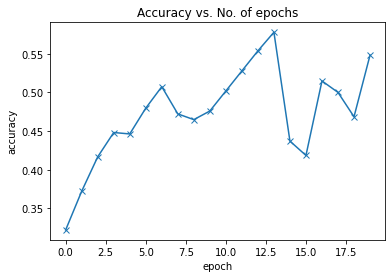

In [ ]:
plot_accuracies(history)

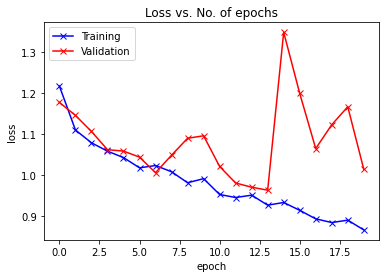

In [ ]:
plot_losses(history)